## Import important dependencies and paths

In [1]:
import os 
import numpy as np
import pandas as pd
from clustering import *
from data_preparation import *
from docking import *
from utility import rank_correlation
from rdkit.ML.Cluster import Butina
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, SDMolSupplier, AllChem, rdFingerprintGenerator
RDLogger.DisableLog('rdApp.*')  

#### If there is more than one snapshot of a trajectory.
    - make a directory for all snapshots inside **data** directory
    - For now , we work with snapshot A

In [2]:
snapshot_ID = 'A'
protein_file = f"data/{snapshot_ID}/protein_protoss_noligand.pdb"
ref_file = f"data/{snapshot_ID}/ref_ligand.pdb"

### Prepare larger dataset with negative samples with already calculated score.

In [3]:
data_name = 'ecft_scores'
data_size = add_negative_data(data_name)
print(f"Now we have loaded {data_size} molecules save in data/ligands/{data_name}.sdf, which contains negative samples.")

,HIPS code,Lab code,MW,logS,logS @ pH7.4,logD,logP,HBD,HBA,TPSA,Flexibility,Rotatable Bonds,ID,ROMol,score
311,HIPS314,MZ045,245.2,3.451,3.494,2.218,2.018,1,5,74.17,0.1667,3,StarDrop ID 312,<rdkit.Chem.rdchem.Mol object at 0x7f9d994557b0>,0.493686
337,HIPS341,JHS014,449.4,-0.8367,2.185,2.827,5.787,2,5,69.64,0.2581,8,StarDrop ID 338,<rdkit.Chem.rdchem.Mol object at 0x7f9d99464350>,-0.265965
338,HIPS342,JHS015,415.3,-0.3106,2.281,2.323,5.668,3,5,78.43,0.3704,10,StarDrop ID 339,<rdkit.Chem.rdchem.Mol object at 0x7f9d994643c0>,-0.371074
339,HIPS343,JHS017,421.3,-0.3253,2.435,2.421,5.322,3,5,78.43,0.2414,7,StarDrop ID 340,<rdkit.Chem.rdchem.Mol object at 0x7f9d99464430>,-0.357913
341,HIPS345,JHS021,435.3,-0.5078,2.529,2.489,5.526,2,5,69.64,0.2333,7,StarDrop ID 342,<rdkit.Chem.rdchem.Mol object at 0x7f9d99464510>,-0.550434


Now we have loaded 212 molecules save in data/ligands/ecft_scores.sdf, which contains negative samples.



### Data preparation
####  1. Protein is prepared with protoss on ProteinPlus server (Done).
####  2. Ligand will be prepared using Gypsum-DL.

In [4]:
# Determine path of data set and run Gypsum-dl
prepared_molecules_path = run_gypsumdl(f"data/ligands/{data_name}.sdf", f"gypsum_dl_success_cleaned_{data_size}.sdf")

Molecules are already prepared


## Docking

## 1. DiffDOCK
### Prepare ligand protein csv file for DiffDock

### Run DiffDock (Left to run on cluster)

In [5]:
#run_diffdock(snapshot_ID, data_size)

## 2. GNINA 1.0 docking 
### with -cnn crossdock_default2018

#### Run GNINA docking

In [6]:
#
sdf_name = f'docked_gnina_poses_{snapshot_ID}_{data_size}.sdf'

In [7]:
gnina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

Snapshot A is already docked with GNINA v 1.0


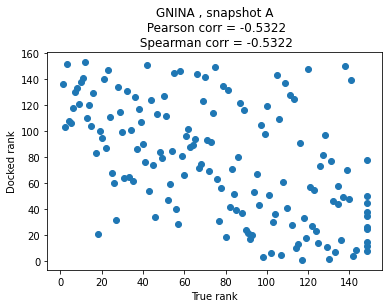

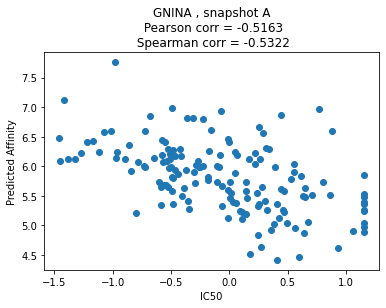

In [8]:
gnina_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(gnina_results_path)

### SMINA docking

#### Run SMINA docking --cnn_scoring=none

In [9]:
sdf_name = f'docked_smina_poses_{snapshot_ID}_{data_size}.sdf'

In [10]:
smina_docking(snapshot_ID, sdf_name, prepared_molecules_path, ref_file)

Snapshot A is already docked with SMINA


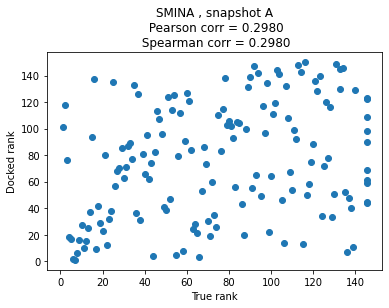

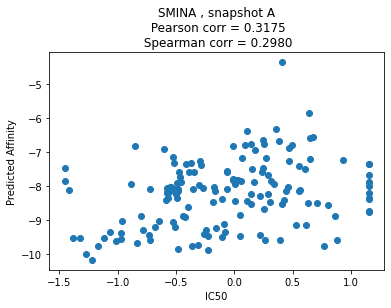

In [11]:
smina_results_path = f'data/{snapshot_ID}/{sdf_name}'
rank_correlation(smina_results_path)

### Try rescoring function with every

rescoring directory is already created.
SMINA is now rescored ... 



RF-SCORE-VS Running ... 





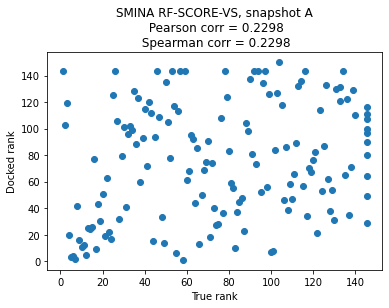

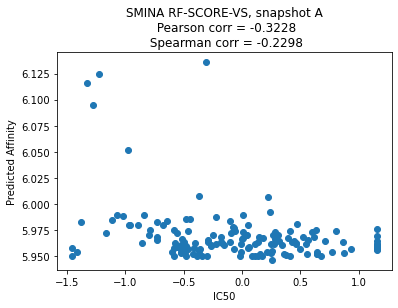

VINARDO Running ... 





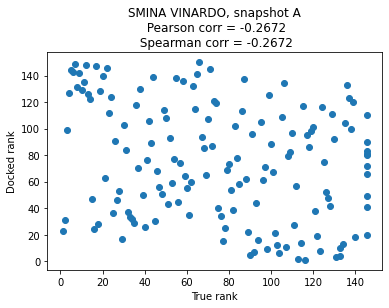

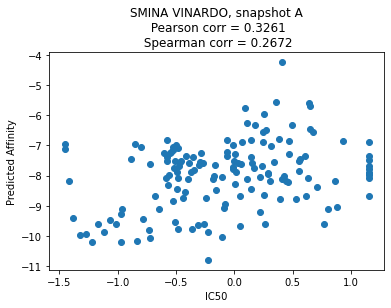

AD4 Running ... 





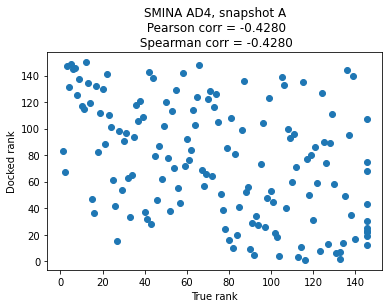

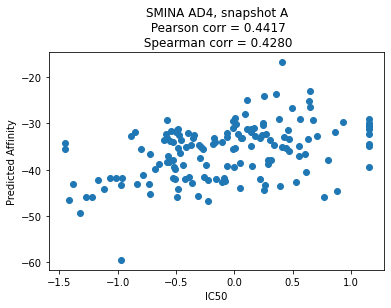

GNINA is now rescored ... 



RF-SCORE-VS Running ... 





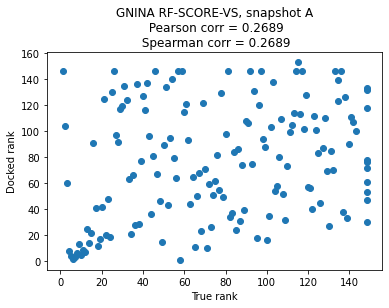

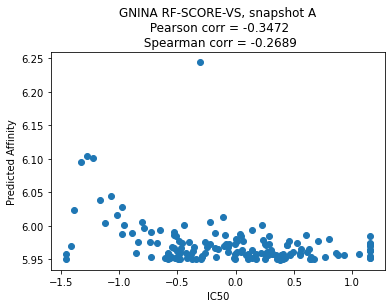

VINARDO Running ... 





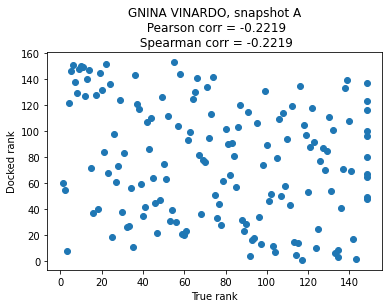

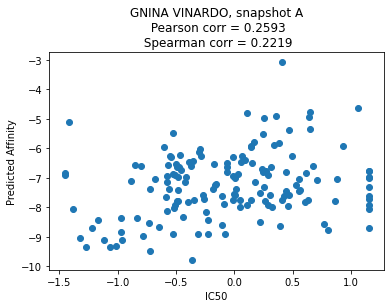

AD4 Running ... 





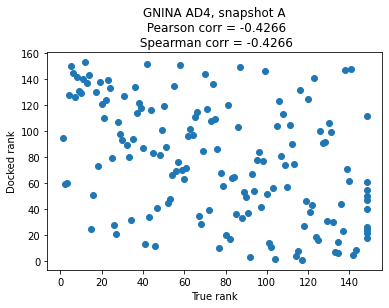

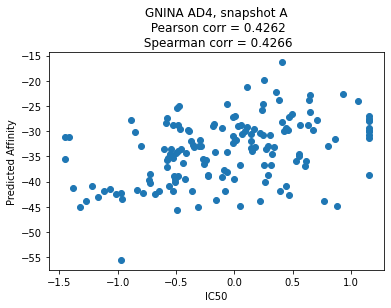

In [12]:
from rescoring import rescoring_functions
rescoring_functions(['smina', 'gnina'], ['rf-score-vs', 'vinardo', 'ad4'], snapshot_ID, data_size)

### FP generating and clustering based on Tanimoto similarity metric for larger data

In [13]:
# Add column with Morgan fingerprint
docked_df = PandasTools.LoadSDF(gnina_results_path, idName='ID', molColName='Molecule', strictParsing=False)
docked_df['MorganFP'] = docked_df.Molecule.apply(morgan_fp_generator)
docked_df.head()

,score,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,ID,Molecule,MorganFP
0,0.493686,-6.66493,0.8810666203,5.1966133118,4.5785627365,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f9d98e31a50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,0.493686,-5.72351,0.7941305041,5.3596706390,4.2562780380,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f9d98e31c10>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0.493686,-6.79467,0.7786121964,5.0351457596,3.9204258919,HIPS314,<rdkit.Chem.rdchem.Mol object at 0x7f9d98e315f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,-0.265965,-7.77134,0.3771519363,6.0932388306,2.2980768681,HIPS341,<rdkit.Chem.rdchem.Mol object at 0x7f9d98e31f20>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,-0.265965,-8.07241,0.3593167067,6.2334060669,2.2397668362,HIPS341,<rdkit.Chem.rdchem.Mol object at 0x7f9d98e31200>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


#### Generate tanimoto similarity matrix

In [14]:
tanimoto_matrix = tanimoto_distance_matrix((docked_df.MorganFP.to_list()))

#### Choice of butina clustering cutoff 
**Inspired by T05 teachOpenCADD Talktorial**

### Choice of cutoff.
#### Choose the cutoff that has clusters equal or bigger than used data.

In [15]:
cutoff = choice_of_cutoff(docked_df)
cutoff

0.9

In [16]:
#Save cluster centers as SDF
# cutoff is chosen to be 0.1 which has 88 clusters
cutoff = 0.1

butina_clusters = butina_clustering(docked_df.MorganFP.to_list(), cutoff=cutoff)

cluster_centers_ind = [c[0] for c in butina_clusters]
cluster_centers_df = docked_df[docked_df.index.isin(cluster_centers_ind)]
display(cluster_centers_df.sort_values('minimizedAffinity'))
cluster_path = 'data/ligands/clustered_poses_212.sdf'

PandasTools.WriteSDF(cluster_centers_df, cluster_path,idName="ID", molColName='Molecule', properties=cluster_centers_df.columns)

,score,minimizedAffinity,CNNscore,CNNaffinity,CNN_VS,ID,Molecule,MorganFP
391,0.176673,-5.16409,0.6609857678,4.5137567520,2.9835290909,HIPS6785,<rdkit.Chem.rdchem.Mol object at 0x7f9d98d3ccf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
222,0.640496,-5.32986,0.8656404018,5.1880092621,4.4909505844,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f9d98b10d60>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
223,0.640496,-5.41926,0.7867473364,4.8761281967,3.8362808228,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f9d98b10ba0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
224,0.640496,-5.49521,0.7826318145,5.0785446167,3.9746305943,HIPS5963,<rdkit.Chem.rdchem.Mol object at 0x7f9d98b10820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
379,0.273774,-5.90086,0.6751087904,4.6322088242,3.1272449493,HIPS6708,<rdkit.Chem.rdchem.Mol object at 0x7f9d98d3ce40>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...
458,-0.839276,-8.86450,0.5565002561,5.9264574051,3.2980749607,HIPS6981,<rdkit.Chem.rdchem.Mol object at 0x7f9d98d20740>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
259,-0.725974,-8.93809,0.5806342959,6.2956209183,3.6554534435,HIPS6066,<rdkit.Chem.rdchem.Mol object at 0x7f9d98b13120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
457,-0.839276,-8.94038,0.5596333742,6.4661188126,3.6186559200,HIPS6981,<rdkit.Chem.rdchem.Mol object at 0x7f9d98d206d0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
366,-0.247372,-8.94737,0.6001500487,6.1496162415,3.6906924248,HIPS6701,<rdkit.Chem.rdchem.Mol object at 0x7f9d98d9cba0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Test DockM8

In [ ]:
from scipy.stats import spearmanr


def compare_rank(df1, df2):

    df2.drop_duplicates(subset='ID', inplace=True)
    df1 = df1[df1['ID'].isin(df2['ID'])]
    df1['old rank'] = df1['Activity'].apply(pd.to_numeric).rank()

    # df2.set_index('ID',inplace=True)
    df2.index = df2.index + 1
    # display(df2.index)
    
    df2['new rank'] = range(1, df2.shape[0]+1)
    df1.sort_values('ID', inplace=True)
    df2.sort_values('ID', inplace=True)
    display(df1)
    display(df2)
    index1 = df1.index
    index2 = df2.index

# Calculate the correlation between the two indices
    correlation = index1.to_series().corr(index2.to_series())
    print(correlation)
    rank_corr = df1['old rank'].corr(df2['new rank'])
    rho = spearmanr(df1['old rank'], df2['new rank'])[0]
    print(rho)
    plt.scatter(df1['old rank'], df2['new rank'])
    print(rank_corr)
    plt.xlabel('True rank')
    plt.ylabel('Docked rank')
    plt.title(f'DockM8 bestpose SMINA \n Pearson corr = {rank_corr:.4f}\n Spearman corr = {rho:.4f}')
    plt.show()
    print('\n\n')
    

path = os.getcwd()+'/data/firstpose_47mol/temp/ranking/'
true_df = PandasTools.LoadSDF('data/ligands/IC50_mol_only.sdf', idName="ID")[['ID', 'Activity']]
true_df['old rank'] = true_df['Activity'].apply(pd.to_numeric).rank()


for f in os.listdir(path):
    print(f)
    compare_rank(true_df, pd.read_csv(path+f))
    # break
    display(pd.read_csv(path+f))

NameError: name 'os' is not defined